In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
import researchpy as rp
from scipy import stats
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_fscore_support, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
%run '/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/src/models.py'

Using TensorFlow backend.


In [4]:
df = pd.read_csv('/Users/claudiostaub/galvanize/capstones/Predicting_Hospital_Readmissions/data/clean_df')
df.columns

Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'change', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_1',
       'gender_Unknown/Invalid', 'max_glu_serum_>300', 'max_glu_serum_None',
       'max_glu_serum_Norm', 'A1Cresult_>8', 'A1Cresult_None',
       'A1Cresult_Norm', 'metformin_No', 'metformin_Steady', 'metformin_Up',
       'repaglinide_No', 'repaglinide_Steady', 'repaglinide_Up',
       'nateglinide_No', 'nateglinide_Steady', 'nateglinide_Up',
       'chlorpropamide_No', 'chlorpropamide_Steady', 'chlorpropamide_Up',
       'glimepiride_No', 'glimepiride_Steady', 'glimepiride_Up',
       'acetohexamide_Steady', 'glipizide_No', 'glipizide_Steady',
       'glip

In [27]:
df.drop(['Unnamed: 0', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)
df.rename(columns={'readmit_True':'readmit'}, inplace=True)

### Base Models and feature set

In [133]:
# X = np.array(df.drop('readmit', axis=1).values)
# y  = np.array(df[['readmit']])

X = df.drop('readmit', axis=1)
y  = df['readmit']


df['readmit'].value_counts()

0    83900
1    10763
Name: readmit, dtype: int64

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

The value_counts clearly shows an imbalanced dataset which is to be expected in hospital readmissions. There are a number of ways to deal with imbalanced data and we will discuss some of the techniques below. 
To get a baseline, we will run a Logistic Regression model without applying any of these techniques. 

In [199]:

lr1 = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = lr1.predict(X_test)

conf1 = confusion_matrix(y_test, y_pred)
print(conf1)
# '''
# [TN | FP
# ____|___
#     |
#  FN | TP]
# '''

[[16698    34]
 [ 2168    33]]


In [200]:
accuracy_score(y_pred, y_test)

0.8836951354777373

Confusion Matrix shows a lot of False Negatives. The model missed about 99% of the readmitted patients. This is an artifact of attempting to fit a model on imbalanced data. 

Accuracy is not the metric to use in assessing models built on imbalanced data sets as you will always get a false high score. 

In [201]:
lr1_auc, lr1_recall, lr1_precision, lr1_specificity, \
    lr1_prevalence = print_report(y_test, y_pred, 0.5)
print(f1_score(y_test, y_pred))

AUC:0.506
recall:0.015
precision:0.493
specificity:0.998
prevalence:0.116
 
0.029100529100529102


In [204]:
rf1 = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = rf1.predict(X_test)
confusion_matrix(y_test, y_pred_rf)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[16650,    82],
       [ 2174,    27]])

In [205]:
rf1_auc, rf1_recall, rf1_precision, rf1_specificity, \
    rf1_prevalence = print_report(y_test, y_pred_rf, 0.5)
print(f1_score(y_test, y_pred_rf))

AUC:0.504
recall:0.012
precision:0.248
specificity:0.995
prevalence:0.116
 
0.023376623376623374


#### Resampling Upsample

In [140]:
from sklearn.utils import resample

In [146]:
upsampled = pd.concat([X_train, pd.Series(y_train)], axis=1)
upsampled.shape


(75730, 75)

In [148]:
readmit = upsampled[upsampled.readmit == True]
negative = upsampled[upsampled.readmit == False]
# print(readmit.shape, negative.shape)
readmit_upsampled = resample(readmit, 
                            replace=True,
                            n_samples=len(negative),
                            random_state=27)

upsampled = pd.concat([negative, readmit_upsampled], axis=0)
upsampled.readmit.value_counts()

1    67168
0    67168
Name: readmit, dtype: int64

In [150]:
y_train1 = upsampled.readmit
X_train1 = upsampled.drop('readmit', axis=1)

lr_up = LogisticRegression(solver='liblinear').fit(X_train1, y_train1)
lr_up_pred = lr_up.predict(X_test)


In [151]:
lr_up_auc, lr_up_recall, lr_up_precision, lr_up_specificity, \
    lr_up_rf1_prevalence = print_report(y_test, lr_up_pred, 0.5)
print(f1_score(y_test, lr_up_pred))

AUC:0.593
recall:0.507
precision:0.172
specificity:0.680
prevalence:0.116
 
0.2572977962386062


In [152]:
rf_up = RandomForestClassifier().fit(X_train1, y_train1)
rf_up_pred = rf_up.predict(X_test)
rf_up_auc, rf_up_recall, rf_up_precision, rf_up_specificity, \
    rf_up_prevalence = print_report(y_test, rf_up_pred, 0.5)
print(f1_score(y_test, rf_up_pred))

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC:0.511
recall:0.040
precision:0.233
specificity:0.983
prevalence:0.116
 
0.06757281553398059


#### Resampling Downsampling

In [157]:
downsampled = pd.concat([X_train, pd.Series(y_train)], axis=1)
downsampled.shape


(75730, 75)

In [159]:
readmit = downsampled[downsampled.readmit == True]
negative = downsampled[downsampled.readmit == False]
print(readmit.shape, negative.shape)
negative_downsampled = resample(negative, 
                            replace=False,
                            n_samples=len(readmit),
                            random_state=27)

downsampled = pd.concat([readmit, negative_downsampled], axis=0)
downsampled.readmit.value_counts()

(8562, 75) (67168, 75)


1    8562
0    8562
Name: readmit, dtype: int64

In [160]:
y_train2 = downsampled.readmit
X_train2 = downsampled.drop('readmit', axis=1)

lr_down = LogisticRegression(solver='liblinear').fit(X_train2, y_train2)
lr_down_pred = lr_down.predict(X_test)


In [161]:
lr_down_auc, lr_down_recall, lr_down_precision, lr_down_specificity, \
    lr_down_prevalence = print_report(y_test, lr_down_pred, 0.5)
print(f1_score(y_test, lr_down_pred))

AUC:0.591
recall:0.502
precision:0.171
specificity:0.679
prevalence:0.116
 
0.2549562010142923


In [162]:
rf_down = RandomForestClassifier().fit(X_train2, y_train2)
rf_down_pred = rf_down.predict(X_test)
rf_down_auc, rf_down_recall, rf_down_precision, rf_down_specificity, \
    rf_down_prevalence = print_report(y_test, rf_down_pred, 0.5)
print(f1_score(y_test, rf_down_pred))

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC:0.573
recall:0.482
precision:0.159
specificity:0.664
prevalence:0.116
 
0.23887323943661973


#### SMOTE

The first method for dealing with imbalanced data is the Synthetic Minority Oversampling Techique (SMOTE). This technique draws lines between the existing minority cluster and generates data points on those lines until the dataset is balanced. 

In [174]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.25, random_state=0)

In [175]:
pd.Series(y_train_sm).value_counts()

0    62945
1     8052
Name: readmit, dtype: int64

In [176]:
smt = SMOTE(random_state=0)
X_train_sm, y_train_sm = smt.fit_sample(X_train_sm, y_train_sm)

Reviewing value counts after SMOTE shows that the training dataset is nowbalanced. 

In [177]:
pd.Series(y_train_sm).value_counts()

1    62945
0    62945
dtype: int64

In [183]:
smote_lr = LogisticRegression(solver='liblinear').fit(X_train_sm, y_train_sm)
smote_lr_pred = smote_lr.predict(X_test_sm)
lr_smt_auc, lr_smt_recall, lr_smt_precision, lr_smt_specificity, \
    lr_smt_prevalence = print_report(y_test_sm, smote_lr_pred, 0.5)
print(f1_score(y_test_sm, smote_lr_pred))

AUC:0.587
recall:0.527
precision:0.162
specificity:0.646
prevalence:0.115
 
0.24729413802060782


In [182]:
smote_rf = RandomForestClassifier().fit(X_train_sm, y_train_sm)
smote_rf_pred = smote_rf.predict(X_test_sm)
rf_smt_auc, rf_smt_recall, rf_smt_precision, rf_smt_specificity, \
    rf_smt_prevalence = print_report(y_test_sm, smote_rf_pred, 0.5)
print(f1_score(y_test_sm, smote_rf_pred))

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC:0.509
recall:0.025
precision:0.287
specificity:0.992
prevalence:0.115
 
0.04613297150610583


#### NearMiss

In [185]:
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X, y, test_size=0.25, random_state=0)

In [186]:
pd.Series(y_train_nm).value_counts()

0    62945
1     8052
Name: readmit, dtype: int64

In [187]:
nm = NearMiss(random_state=0)
X_train_nm, y_train_nm = nm.fit_sample(X_train_nm, y_train_nm)

In [188]:
pd.Series(y_train_nm).value_counts()

1    8052
0    8052
dtype: int64

In [189]:
nm_lr = LogisticRegression(solver='liblinear').fit(X_train_nm, y_train_nm)
nm_lr_pred = nm_lr.predict(X_test_nm)
lr_nm_auc, lr_nm_recall, lr_nm_precision, lr_nm_specificity, \
    lr_nm_prevalence = print_report(y_test_nm, nm_lr_pred, 0.5)
print(f1_score(y_test_nm, nm_lr_pred))

AUC:0.534
recall:0.761
precision:0.124
specificity:0.307
prevalence:0.115
 
0.21365661589472593


In [195]:
nm_rf = RandomForestClassifier().fit(X_train_nm, y_train_nm)
nm_rf_pred = nm_rf.predict(X_test_nm)
rf_nm_auc, rf_nm_recall, rf_nm_precision, rf_nm_specificity, \
    rf_nm_prevalence = print_report(y_test_nm, nm_rf_pred, 0.5)
print(f1_score(y_test_nm, nm_rf_pred))

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC:0.525
recall:0.737
precision:0.122
specificity:0.312
prevalence:0.115
 
0.20903482170866883


In [193]:
confusion_matrix(y_test_nm, nm_lr_pred)

array([[ 6426, 14529],
       [  649,  2062]])

In [64]:
lr2 = LogisticRegression()
lr2.fit(X_train_sm1, y_train_sm1)
y_pred_lr2 = lr2.predict(X_test1)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [48]:
lr2train_auc, lr2train_recall, lr2train_precision, \
    lr2train_specificity, lr2train_prevalence = print_report(y_train1, lr2.predict(X_train1), 0.5)
# validation score

AUC:0.575
recall:0.537
precision:0.581
specificity:0.613
prevalence:0.500
 


In [65]:
lr2_auc, lr2_recall, lr2_precision, lr2_specificity, \
    lr2_prevalence = print_report(y_test1, y_pred_lr2, 0.5)

# test scores

AUC:0.570
recall:0.535
precision:0.151
specificity:0.604
prevalence:0.116
 


In [66]:
confusion_matrix(y_test1, y_pred_lr2)
# '''
# [TN | FP
# ____|___
#     |
#  FN | TP]
# '''

array([[10114,  6618],
       [ 1023,  1178]])

In [67]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_sm1, y_train_sm1)
y_pred_rf2 = rf2.predict(X_test1)
confusion_matrix(y_test1, y_pred_rf1)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[16084,   648],
       [ 2057,   144]])

In [68]:
rf2_auc, rf2_recall, rf2_precision, rf2_specificity, \
    rf2_prevalence = print_report(y_test1, y_pred_rf2, 0.5)
 

AUC:0.518
recall:0.272
precision:0.132
specificity:0.764
prevalence:0.116
 


In [93]:
nm = NearMiss()
X_train_nm, y_train_nm = nm.fit_sample(X_train1, y_train1)

np.bincount(y_train_nm)

array([8562, 8562])

In [94]:
lr3 = LogisticRegression()
lr3.fit(X_train_nm, y_train_nm)
y_pred_lr3 = lr3.predict(X_test1)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [95]:
lr3_auc, lr3_recall, lr3_precision, lr3_specificity, \
    lr3_prevalence = print_report(y_test1, y_pred_lr3, 0.5)


AUC:0.548
recall:0.705
precision:0.132
specificity:0.391
prevalence:0.116
 


In [96]:
confusion_matrix(y_test1, y_pred_lr3)

array([[ 6549, 10183],
       [  650,  1551]])

In [97]:
rf3 = RandomForestClassifier()
rf3.fit(X_train_nm, y_train_nm)
y_pred_rf3 = rf3.predict(X_test1)
confusion_matrix(y_test1, y_pred_rf3)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[ 4967, 11765],
       [  503,  1698]])

In [98]:
rf3_auc, rf3_recall, rf3_precision, rf3_specificity, \
    rf3_prevalence = print_report(y_test1, y_pred_rf3, 0.5)

AUC:0.534
recall:0.771
precision:0.126
specificity:0.297
prevalence:0.116
 


Owing to the poor predictive power of the continuous features used in above feature set, it follows that our model is not performing well.  

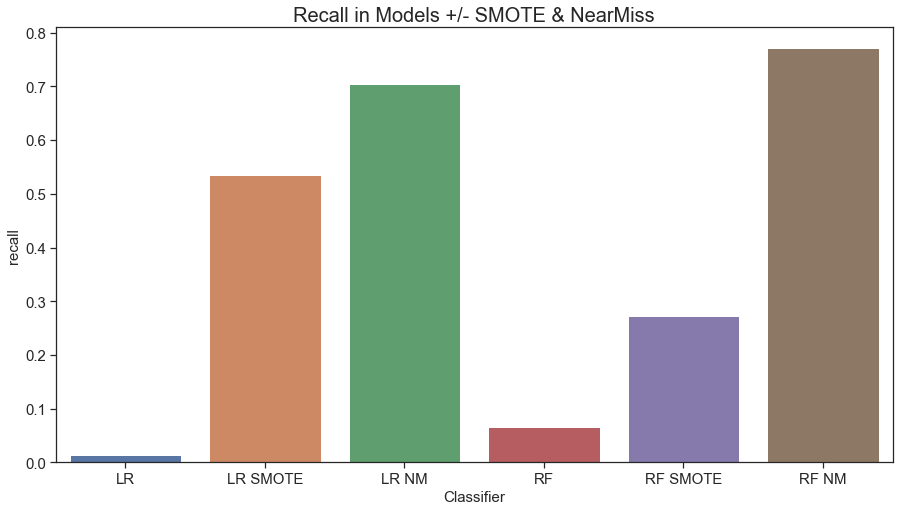

In [102]:
results = pd.DataFrame({'classifier':['LR','LR SMOTE','LR NM','RF', 'RF SMOTE', 'RF NM'],
                       'auc':[lr1_auc, lr2_auc,lr3_auc, rf1_auc, rf2_auc, rf3_auc],                    
                       'recall':[lr1_recall, lr2_recall, lr3_recall, rf1_recall, rf2_recall, rf3_recall],
                       'precision':[lr1_precision, lr2_precision, lr3_precision,  rf1_precision, rf2_precision, rf3_precision],
                       'specificity':[lr1_specificity, lr2_specificity, lr3_specificity, rf1_specificity, rf2_specificity, rf3_specificity]                        
                       })
plt.figure(figsize=(15,8))
ax = sns.barplot(x="classifier", y="recall", data=results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('recall', fontsize = 15)
ax.tick_params(labelsize=15)
ax.set_title('Recall in Models +/- SMOTE & NearMiss',fontsize=20)

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

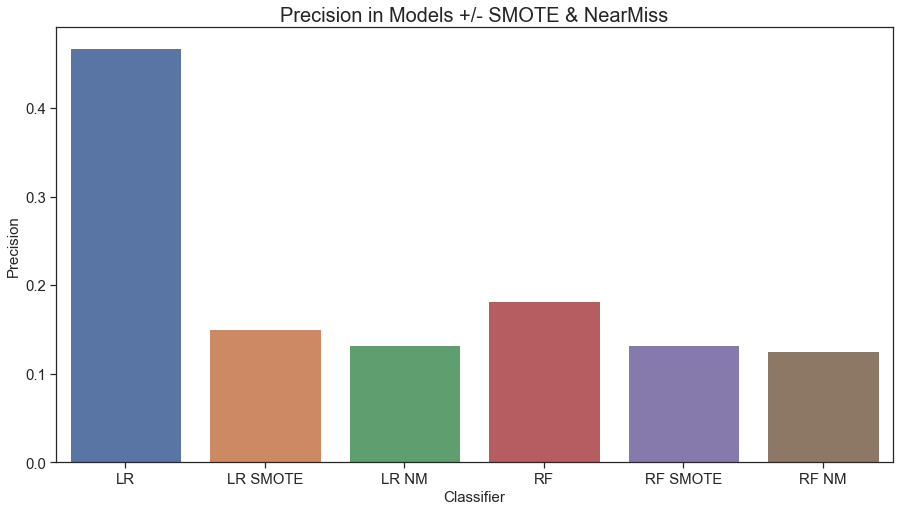

In [103]:
results = pd.DataFrame({'classifier':['LR','LR SMOTE','LR NM','RF', 'RF SMOTE', 'RF NM'],
                       'auc':[lr1_auc, lr2_auc,lr3_auc, rf1_auc, rf2_auc, rf3_auc],                    
                       'recall':[lr1_recall, lr2_recall, lr3_recall, rf1_recall, rf2_recall, rf3_recall],
                       'precision':[lr1_precision, lr2_precision, lr3_precision,  rf1_precision, rf2_precision, rf3_precision],
                       'specificity':[lr1_specificity, lr2_specificity, lr3_specificity, rf1_specificity, rf2_specificity, rf3_specificity]                        
                       })
plt.figure(figsize=(15,8))
ax = sns.barplot(x="classifier", y="precision", data=results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('Precision', fontsize = 15)
ax.tick_params(labelsize=15)
ax.set_title('Precision in Models +/- SMOTE & NearMiss',fontsize=20)

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()